In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    X = X.T
    Y = Y.T
    return X, Y

X, Y = load_planar_dataset()

def split(X, Y, ratio, rand_state=1):
    X = X.T
    Y = Y.T
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio, random_state=rand_state)
    X_train = X_train.T
    X_test = X_test.T
    Y_train = Y_train.T
    Y_test = Y_test.T
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split(X, Y, 0.2)
print(X_train.shape, Y_train.shape)

(2, 320) (1, 320)


In [3]:
# Activation functions
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def relu(z):
    a = np.maximum(0, z)
    return a

def tanh(z):
    a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    return a

def activate(z, act):
    if act == "sigmoid":
        return sigmoid(z)
    elif act == "relu":
        return relu(z)
    else:
        return tanh(z)

# Gradient calculations
def backward_propagation_sigmoid(dal, wl, zl, al_1):
    m = dal.shape[-1]
    al = sigmoid(zl)
    dzl = dal * al * (1 - al)
    dwl = 1/m*np.dot(dzl, al_1.T)
    dbl = 1/m*np.sum(dzl, axis=1, keepdims=True)
    dal_1 = np.dot(wl.T, dzl)
    return dal_1, dwl, dbl

def backward_propagation_relu(dal, wl, zl, al_1):
    m = dal.shape[-1]
    al = relu(zl)
    dal_dzl = zl >= 0
    dal_dzl = dal_dzl.astype("int")
    dzl = dal*dal_dzl
    dwl = 1/m*np.dot(dzl, al_1.T)
    dbl = 1/m*np.sum(dzl, axis=1, keepdims=True)
    dal_1 = np.dot(wl.T, dzl)
    return dal_1, dwl, dbl

def backward_propagation_tanh(dal, wl, zl, al_1):
    m = dal.shape[-1]
    al = tanh(zl)
    dzl = dal*(1-al**2)
    dwl = 1/m*np.dot(dzl, al_1.T)
    dbl = 1/m*np.sum(dzl, axis=1, keepdims=True)
    dal_1 = np.dot(wl.T, dzl)
    return dal_1, dwl, dbl

def backward_propagation(dal, wl, zl, al_1, act):
    if act == "sigmoid":
        return backward_propagation_sigmoid(dal, wl, zl, al_1)
    elif act == "relu":
        return backward_propagation_relu(dal, wl, zl, al_1)
    else:
        return backward_propagation_tanh(dal, wl, zl, al_1)

# Layer class
class layer:
    def __init__(self, shape, activation):
        self.W = np.random.randn(*shape)*0.01
        self.b = np.zeros((shape[0], 1))
        self.activation = activation
        
    def forward(self, x):
        assert self.W.shape[-1] == x.shape[0]
        assert self.W.shape[0] == self.b.shape[0]
        z = np.dot(self.W, x) + self.b
        a = activate(z, self.activation)
        return a, z, self.W, x

# create batches of data
def batchify(X, Y, batch_size):
    m = X.shape[-1]
    for idx in range(0, m, batch_size):
        yield(X[:, idx:min(idx + batch_size, m)], Y[:, idx:min(idx + batch_size, m)])    

    
# Network class
class network:
    def __init__(self):
        self.layers = []
    
    def forward_propagate(self, X):
        cache = {}
        al = X
        for layer, i in zip(self.layers, range(1, len(self.layers)+1)):
            al, zl, wl, al_1 = layer.forward(al)
            cache["l" + str(i)] = [zl, wl, al_1]
        return al, cache
    
    def backward_propagate(self, Y_hat, Y, cache):
        grads = {}
        dzl = Y_hat - Y
        dal = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        for layer, i in zip(reversed(self.layers), reversed(range(1, len(self.layers)+1))):
            zl, wl, al_1 = cache["l" + str(i)]
            al = sigmoid(zl)
            dal, dwl, dbl = backward_propagation(dal, wl, zl, al_1, self.layers[i-1].activation)
            grads["dW" + str(i)] = dwl
            grads["db" + str(i)] = dbl
        return grads
    
    def cost(self, Y_hat, Y):
        m = Y.shape[-1]
        J = -1/m*np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat))
        return J
    
    def update(self, grads, learning_rate):
        for layer, i in zip(self.layers, range(1, len(self.layers)+1)):
            layer.W = layer.W - learning_rate * grads["dW" + str(i)]
            layer.b = layer.b - learning_rate * grads["db" + str(i)]
    
    def train(self, X, Y, epoches, learning_rate, batch_size):
        losses = []
        for i in range(epoches):
            for X_batch, Y_batch in batchify(X, Y, batch_size):
                Y_hat, cache = self.forward_propagate(X_batch)
                J = self.cost(Y_hat, Y_batch)
                grads = self.backward_propagate(Y_hat, Y_batch, cache)
                self.update(grads, learning_rate)
            losses.append(J)
            if i % int(epoches/10) == 0:
                print(J)
        return losses
    
    def predict(self, X, Y):
        Y_hat, cache = self.forward_propagate(X)
        Y_hat = (Y_hat >= 0.5).astype("int")
        acc = (Y_hat == Y).astype("int")
        acc = np.sum(acc)/acc.shape[-1]
        return Y_hat, acc

0.6932485565052859
0.6946529430350894
0.6946362792080001
0.36640960568569114
0.301134606631371
0.26847554483753033
0.258532376947749
0.24921705939990038
0.23168546177212276
0.21375686037472397
test set accuracy: 92.5%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'iteration')]

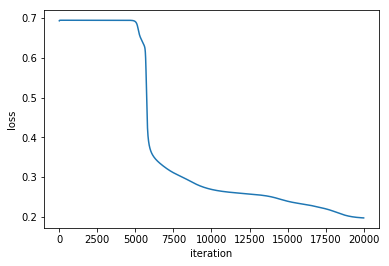

In [4]:
np.random.seed(1)
layers = [layer((4, 2), "sigmoid"), layer((3, 4), "tanh"), layer((1, 3), "sigmoid")]
net = network()
net.layers = layers

iters = 20000
batch_size = 128
losses = net.train(X_train, Y_train, iters, 0.1, batch_size)
Y_hat, acc = net.predict(X_test, Y_test)
print("test set accuracy: "+str(acc*100)+"%")
fig, ax = plt.subplots()
ax.plot(range(iters), losses)
ax.set(xlabel='iteration', ylabel='loss')